# Final Project Random Act of Pizza: 
Delivered by Le Gu, Derek Chan, and Max(Sungtai) Shen

Sunday, April 24, 2016

Table of Contents

    Background description
    
    Data Exploration
    Initial Model Exploration
    Baseline Results
    Numerical Feature Engineering: Process and Results
    Text Feature Engineering: Process and Results
    Model Optimization
    Summary of best predictors
    Ensemble Method and Final Prediction
    
    Appendix
    
Background Description

In [3]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import os
import codecs
import json
import csv

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

# Data Exploration

In [4]:
# set random seed
np.random.seed(0)
#Input data
X = pd.read_json('./pizza_request_dataset.json')
print ("Input Type after pd.read_jason: "), type(X), "\n" 

# randomly assign 70% to train_data, and 30% to dev_data
msk = np.random.rand(len(X)) <= 0.7
train_data = X[msk]
dev_data = X[~msk]

# create output dataframe Y of train_labels
train_labels = train_data[["requester_received_pizza"]]

# delete train_labels from input dataframe of train_data
del train_data["requester_received_pizza"]

# create output dataframe of dev_labels
dev_labels = dev_data[["requester_received_pizza"]]

# delete dev_labels from input dataframe of dev_data
del dev_data["requester_received_pizza"]

# print (labels, shapes, and feature names
print ("train_labels" + "\n" + "----------")
print (list(train_labels))
print (train_labels.shape), "\n" 
print ("train_data" + "\n" + "----------") 
print (list(train_data))
print (train_data.shape), "\n"

print ("dev_labels" + "\n" + "----------")
print (list(dev_labels))
print (dev_labels.shape), "\n"

print ("dev_data" + "\n" + "----------")
print (list(dev_data))
print (dev_data.shape), "\n"

# print (percent of train_data and dev_data whose posts led to receipt of pizza
print ("train labels" + "\n" + "----------")
print (np.mean(train_labels)), "\n"
print ("dev labels" + "\n" + "----------")
print (np.mean(dev_labels))

Input Type after pd.read_jason:  <class 'pandas.core.frame.DataFrame'> 

train_labels
----------
[u'requester_received_pizza']
(3975, 1) 

train_data
----------
[u'giver_username_if_known', u'in_test_set', u'number_of_downvotes_of_request_at_retrieval', u'number_of_upvotes_of_request_at_retrieval', u'post_was_edited', u'request_id', u'request_number_of_comments_at_retrieval', u'request_text', u'request_text_edit_aware', u'request_title', u'requester_account_age_in_days_at_request', u'requester_account_age_in_days_at_retrieval', u'requester_days_since_first_post_on_raop_at_request', u'requester_days_since_first_post_on_raop_at_retrieval', u'requester_number_of_comments_at_request', u'requester_number_of_comments_at_retrieval', u'requester_number_of_comments_in_raop_at_request', u'requester_number_of_comments_in_raop_at_retrieval', u'requester_number_of_posts_at_request', u'requester_number_of_posts_at_retrieval', u'requester_number_of_posts_on_raop_at_request', u'requester_number_of_pos

In [5]:
# prepare data
# transform X to numpy array, and Y to 1-D numpy array
# view actual text and labels
train_text = train_data["request_text"]
dev_text = dev_data["request_text"]

print ("type(train_text)"), type(train_text)
print ("type(train_labels)"), type(train_labels)
print ("type(dev_text)"), type(dev_text)
print ("type(dev_labels)"), type(dev_labels), "\n"

# View as pandas dataframe
print ("pandas dataframe:")
print (train_text[:5]), "\n"

# convert to numpy (np) array
def to_np(d):

    print ("numpy.ndarray:")
    d = np.array(d)
    d = d.flatten()
    print (type(d))
    print (d.shape)
    print (d[:3])
    print
    return d

train_text = to_np(train_text)
train_labels = to_np(train_labels)
dev_text = to_np(dev_text)
dev_labels = to_np(dev_labels)

print ("train_labels.shape: "), train_labels.shape
print ("dev_labels.shape: "), dev_labels.shape

type(train_text) <class 'pandas.core.series.Series'>
type(train_labels) <class 'pandas.core.frame.DataFrame'>
type(dev_text) <class 'pandas.core.series.Series'>
type(dev_labels) <class 'pandas.core.frame.DataFrame'> 

pandas dataframe:
0    I'm not in College, or a starving artist or an...
2    I'm sure there are needier people on this subr...
3    I've been unemployed going on three months now...
4    I ran out of money on my meal card a while bac...
5                                                     
Name: request_text, dtype: object 

numpy.ndarray:
<type 'numpy.ndarray'>
(3975,)
[ u"I'm not in College, or a starving artist or anything like that. I've just been a bit unlucky lately. I'm a 36 year old single guy with a job. But rent, and other bills killed me this month. I thought I had enough funds in my account to at least keep me set with Mr. Noodles, I forgot about my monthly banking fee.\n\nI had a small bag of chips Wednesday afternoon, and I get paid Monday, so I'll be fine

##a) Test Different Models

In [6]:
import operator

def explore_models():
    
    # create empty vector
    accuracies = []
    
    vectorizer = TfidfVectorizer(min_df=1, stop_words='english')
    #vectorizer = CountVectorizer(min_df=1, stop_words='english')
    train_vectors = vectorizer.fit_transform(train_text)
    print ("train_vectors.shape:", train_vectors.shape)
    
    dev_vectors = vectorizer.transform(dev_text)
    print ("dev_vectors.shape:", dev_vectors.shape), '\n'
    
    #------------------------
    # K Nearest Neighbors
    #------------------------
    
    print ("------------------------------")
    print ("K Nearest Neighbors (K-NN)")
    print ("------------------------------")
    
    ks = [1, 5, 15, 16, 17, 18, 19, 20, 28, 29, 30, 31, 32, 150, 300]
    f1_scores = []
    
    for k in ks:
        knn = KNeighborsClassifier(n_neighbors=k, algorithm='brute')
        knn.fit(train_vectors, train_labels)
        pred_1 = knn.predict(dev_vectors)
            
        print ("K-NN: f1_score = %s, k = %s" %(round(metrics.f1_score(dev_labels, pred_1, average='binary'),4), k))

        # append f1_scores to vector
        f1_scores.append(metrics.f1_score(dev_labels, pred_1))
    
    print
    
    # map two vectors into a dictionary
    results_knn = dict(zip(ks, f1_scores))
    #print (results_knn)
    
    # print (the key with the max fl_score
    print ("K-NN: optimal k =", max(results_knn.items(), key=operator.itemgetter(1))[0]), '\n'

    
    #------------------------
    # Bernoulli Naive Bayes
    #------------------------
    
    print ("-----------------------------")
    print ("Bernoulli Naive Bayes (BNB)")
    print ("-----------------------------")
    
    # create two vectors
    
    alphas = [0.0, 0.00001, 0.0001, 0.001, 0.01, 0.094, 0.095, 0.096, 0.1, 0.105, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 1.0, 10.0]
    f1_scores = []
    
    for a in alphas:
        bnb = BernoulliNB(alpha=a,binarize=0.5)
        bnb.fit(train_vectors, train_labels)
        pred_2 = bnb.predict(dev_vectors)
        print ("BNB: f1_score = %s, alpha = %s" % (round(metrics.f1_score(dev_labels, pred_2, average='binary'), 4), a))
        
        # append f1_scores to vector
        f1_scores.append(metrics.f1_score(dev_labels, pred_2))
        
    print
    
    # map two vectors into a dictionary
    results_bnb = dict(zip(alphas, f1_scores))
    #print (results_mnb)
    
    # print (the key wit)h the max fl_score
    print ("Bernoulli Naive Bayes: optimal alpha =", max(results_bnb.items(), key=operator.itemgetter(1))[0]), '\n'
    
    #------------------------
    # Logistic Regression
    #------------------------
    
    print ("------------------------")
    print ("Logistic Regression (LR)")
    print ("------------------------"), '\n'

    
    # create two vectors
    # cs refers to the vector of C (inverse of regularization strength) values
    
    cs = [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, \
          10, 12, 20, 30, 40, 50, 100, 1000]
    f1_scores = []
    
    for c in cs:
        
        # use l2 regularization, per instructions
        lr = LogisticRegression(penalty='l2',C=c)
        lr.fit(train_vectors, train_labels)
        pred_3 = lr.predict(dev_vectors)
        
        print ("-------------------------------")
        print ("LR: f1_score = %s, C = %s" % (round(metrics.f1_score(dev_labels, pred_3, average='binary'),4), c))
        print ("-------------------------------")
        
        # append f1_scores to vector
        f1_scores.append(metrics.f1_score(dev_labels, pred_3, average='binary'))
        
        accuracies.append((lr.score(dev_vectors, dev_labels))*100) 

        #print (lr.coef_.shape)
        
        # first define function that squares a given value, for later use in the 'for loop' below
        fun_sq_wts = lambda x: x**2
        
        # use map function, likely faster (because written in C) than list comprehension.
        # map function itself applies a function, specifically the first argument on the second argument.
        # from coef_, take raw weights (coefficient of the features in the decision function), 
        # and sum the squares of these weights.

        # note: averege=weight vs. average=default should be about same score if similar number of examples across classes
        sq_wts = map(fun_sq_wts, lr.coef_[0])
        sum_sq_wts =  sum(sq_wts)
        print ("Label = 1, sum of squared weights = %s" % (sum_sq_wts)), '\n'
        
    # map two vectors into a dictionary
    results_lr = dict(zip(cs, f1_scores))
    #print (results_lr)
    
    # print (the key with the max fl_score
    print ("Logistic Regression: optimal C =", max(results_lr.items(), key=operator.itemgetter(1))[0]), '\n'
    print ("max accuracy =", max(accuracies))

explore_models()

('train_vectors.shape:', (3975, 12313))
('dev_vectors.shape:', (1696, 12313)) 

------------------------------
K Nearest Neighbors (K-NN)
------------------------------
K-NN: f1_score = 0.4133, k = 1
K-NN: f1_score = 0.0259, k = 5
K-NN: f1_score = 0.0, k = 15
K-NN: f1_score = 0.0, k = 16
K-NN: f1_score = 0.0, k = 17
K-NN: f1_score = 0.0, k = 18
K-NN: f1_score = 0.0, k = 19
K-NN: f1_score = 0.0, k = 20
K-NN: f1_score = 0.0, k = 28
K-NN: f1_score = 0.0, k = 29
K-NN: f1_score = 0.0, k = 30
K-NN: f1_score = 0.0, k = 31
K-NN: f1_score = 0.0, k = 32
K-NN: f1_score = 0.0, k = 150
K-NN: f1_score = 0.0, k = 300

('K-NN: optimal k =', 1) 

-----------------------------
Bernoulli Naive Bayes (BNB)
-----------------------------
BNB: f1_score = 0.0, alpha = 0.0
BNB: f1_score = 0.0844, alpha = 1e-05
BNB: f1_score = 0.0844, alpha = 0.0001
BNB: f1_score = 0.0844, alpha = 0.001
BNB: f1_score = 0.0125, alpha = 0.01
BNB: f1_score = 0.0126, alpha = 0.094
BNB: f1_score = 0.0126, alpha = 0.095
BNB: f1_score

/Users/Maximus/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1075: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


# Baseline Results
Based on inital results, we proceeded with Logistic Regression as the 

In [7]:
from sklearn.feature_selection import *

def top20(type):
    if type == "unigram":
        
        # use stop_words='english' to remove less meaningful words. 
        # only applies if default analyzer='word'.
        vectorizer = TfidfVectorizer(min_df=1, stop_words='english')
        #vectorizer = CountVectorizer(min_df=1, stop_words='english')
        train_vectors = vectorizer.fit_transform(train_text)
        print
        print ("----------")
        print ("unigram")
        print ("----------")
        print
        print ("train_vectors.shape:", train_vectors.shape)
        print
        
    elif type == "bigram":
        
        # use stop_words='english' to remove less meaningful words from the resulting tokens. 
        # only applies if default analyzer='word'.
        # set bigrams to be 2 words only
        vectorizer = TfidfVectorizer(min_df=1, stop_words='english', ngram_range=(2, 2))
        #vectorizer = CountVectorizer(min_df=1, stop_words='english', ngram_range=(2, 2))
        train_vectors = vectorizer.fit_transform(train_text)
        print
        print ("----------")
        print ("bigram")
        print ("----------")
        print
        print ("train_vectors.shape:", train_vectors.shape)
        print
      
    # use C=12
    for c in [12]:
        
        # in the multiclass case, the training algorithm uses the one-vs-rest (OvR) scheme if the default ‘multi_class’ option is set to ‘ovr’ 
        lr = LogisticRegression(penalty='l2',C=c)
        #print (lr)
        
        # fit the model and generate coef_
        lr.fit(train_vectors, train_labels)
         
        # interested in magnitude of the weights (coefficients), so take absolute value.
        # sort absolute values in descending order.
        # important to know if negative or positive weight, so still output the positive/negative sign.
        # after fitting logistic regression for class vs. all other classes, negative weight of a token 
        # indicates a class other than class of interest.
        # (visual example of negative and positive on a sigmoid function helps) 
        
        print ("lr.coef_:")
        print (lr.coef_), "\n"
        
        # for each label, store the column indices of the top 5 weights 
        top20 = sorted(range(len(lr.coef_[0])), key=lambda i: abs(lr.coef_[0][i]), reverse=True)[:20]
       
        col_1 = []
        
        # for each label, access and store weights via column indices
        for index in (top20):
            col_1.append(lr.coef_[0][index])
        # store feature names, after converting to an array
        feature_names = np.asarray(vectorizer.get_feature_names())
       
        # create a Pandas dataframe with 20 rows and 4 columns, plus descriptive headers
        df = pd.DataFrame({'Feature': feature_names[top20], 'word': col_1})
        print (df)

#-----
top20("unigram")
top20("bigram")


----------
unigram
----------

('train_vectors.shape:', (3975, 12313))

lr.coef_:
[[-1.48092905 -0.39311615 -0.12825177 ...,  0.44453487  1.63180069
  -0.87946286]] 

       Feature      word
0         edit  4.824324
1       father  4.627494
2         mean  4.376547
3      pockets  4.057164
4          ass  3.995387
5    mentioned  3.977975
6          die  3.930683
7        basic  3.899384
8      married  3.850098
9     southern -3.846223
10       bloke  3.807984
11    surprise  3.805289
12   graveyard  3.749854
13   surprised  3.697465
14     sitting -3.697393
15       mommy  3.658543
16  especially  3.627059
17  constantly  3.593246
18      cheesy  3.548595
19     running  3.539010

----------
bigram
----------

('train_vectors.shape:', (3975, 90693))

lr.coef_:
[[-0.31775435  0.42001296 -0.29407174 ..., -0.26401881 -0.22234693
   0.57766744]] 

                Feature      word
0           edit thanks  3.882043
1             imgur com  3.879634
2            http imgur  3.547851
3   

# This section includes several help methods 

#Method for printing results and ROC Curve Plotting

In [129]:
def model_output(pred_probas, F_Score, preds, title=''):
    print ("Number of positive prediction: %d") % (preds.sum())
    print ("Model F-Score = %0.4f "%(F_Score))  #Sum up Squared Weights
    accuracy = np.where(preds==dev_labels, 1, 0).sum() / float(len(dev_labels))
    print ("Accuracy = %0.4f"    % (accuracy))
    print ('precision_score: %f'  % metrics.precision_score(dev_labels, preds))
    print ('recall_score: %0.4f' % metrics.recall_score(dev_labels, preds))
    #print ('roc_auc_score: %0.4f'% metrics.roc_auc_score(dev_labels, preds, 'weighted'))
    
    # to reproduce from Kaggle, dont change weighted argument, just use default
    # http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html
    # https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/auc.py
    
    # don't use 0 or 1, instead use the probabilities but think about it as a ranking score
    # with auc, just want positive examples ranked over the negative examples,
    # does not matter if .99 > .90 or .11 vs. .01
    print ('roc_auc_score: %0.4f'% metrics.roc_auc_score(dev_labels, pred_probas[:,1]))

    
    fpr,tpr,thresholds = roc_curve(dev_labels, pred_probas[:,1])
    table_of_thresholds = pd.DataFrame({'fpr': fpr, 'tpr': tpr, 'thresholds': thresholds})
    roc_auc = auc(fpr,tpr)
    plt.plot(fpr,tpr,label='area = %.4f' %roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.title(title)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')



In [9]:
#Method for tuning L1 and L2 regulations
def Model_Tuning(in_model, in_train, in_label):

    para = {'C': [100, 10, 1, 0.1, 0.01, 0.001, 0.0001, 0.00001]}
    # create and fit a ridge regression model, testing each alpha
    model = in_model
    grid = GridSearchCV(estimator=model, param_grid = para)
    grid.fit(in_train, in_label)
    print "The optimal hyperparameter is: ", grid.best_params_
    return (grid.best_params_)

In [10]:
#Method for doing L1 regulation and finding most significant features
def L1_regulation(C_parameter, in_train, in_label):

    model_LG_L1 = LogisticRegression(penalty ='l1',C=C_parameter)#C from the above test
    model_LG_L1.fit(in_train, in_label)

    #Update the new index
    index=[]
    for i,z in enumerate(np.sum(np.abs(model_LG_L1.coef_),axis=0) ):
        if z!=0:
            index.append(i)
    return(index)        

# Numerical Feature Engineering: Process and Results
This section is the numerical part of the model: utilize all numeric information from the dataset to 
predict the labels.  This model will be combined the text based model to improve predictive power. 

In [11]:
#This is a helper method created for numerical feature extraction
from datetime import date

# define functions for subsequent cell
def avgNumWords(post):
    sentences = [x.strip() for x in post.split('.')]
    num_words = len(post.split(' '))
    num_sentences = len([x.strip() for x in post.split('.')])
    return num_words / num_sentences

def monthsFrom2010(col):
    temp =  col.apply(lambda x: datetime.datetime.fromtimestamp(x).strftime('%Y-%m-%d'))
    temp =  temp.apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))
    
    raop_create_date = datetime.datetime(2010, 12, 1)
    raop_create_date = raop_create_date.date()

    temp = [x.date() for x in temp]
    # comment out days, and use months for better results
    #temp = [(x - raop_create_date).days for x in temp]
    temp = [((x - raop_create_date).days)/30 for x in temp]
    
    return temp

                                       Coefficients
# words in posted title                    0.000238
# words in posted text                     0.000711
Month number of post (1-12)               -0.029972
Posted 2nd half of month?                 -0.178590
Posted past noon CST?                     -0.339503
Upvotes minus Downvotes                    0.000021
Requester account age                      0.000097
Posted on weekend?                        -0.022634
Requester included image?                  0.531343
Posted on holiday?                         0.091636
Post edited by Reddit?                     0.303602
# comments on Reddit at retrieval > 1      1.525285
# posts on RAOP at retrieval > 1           2.450680
Number of sentences > 3                    0.230997
Average words in sentence > 15             0.168713
# Months since RAOP creation 12/2010      -0.029603 

Number of positive prediction: 225
Model F-Score = 0.5783 
Accuracy = 0.8349
accuracy_score: 0.853333
recall_score

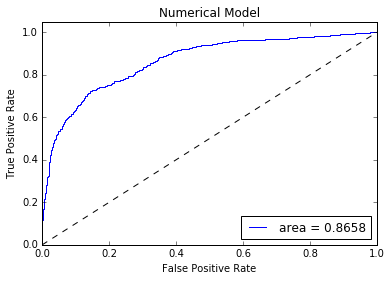

In [12]:
import datetime
from pytz import timezone
from dateutil import tz
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
np.random.seed(0)

#Setting up logic to identify timezone, weekend, and holidays
from_zone = tz.gettz('UTC')
to_zone = tz.gettz('America/Chicago')
weekend = set([5, 6])
cal = calendar()
holidays = cal.holidays(start='2011-04-07', end='2013-10-11')

#Created new df for training data(numeric only)
train_data_numeric = np.zeros((len(train_data), 16))
dev_data_numeric =  np.zeros((len(dev_data), 16))

find_image = re.compile(r'(imgur\.com|\.jpg)')  #compile this to combine with other function

#####Process train data set###########################################################
ut = train_data['unix_timestamp_of_request_utc']
temp =  ut.apply(lambda x: datetime.datetime.fromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))
temp =  temp.apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
utc =   temp.apply(lambda x: x.replace(tzinfo=from_zone))

#For UTC and local time conversion
temp = [] 
for i in utc:
    temp.append(i.astimezone(to_zone))
temp = pd.DataFrame(temp, columns=["T"])
    
train_data_numeric[:,0] = train_data['request_title'].apply(lambda x: len(x.split(' ')))  #Title length
train_data_numeric[:,1] = train_data['request_text'].apply(lambda x: len(x.split(' ')))   #Text length
train_data_numeric[:,2] = temp['T'].dt.month      #Month in integer
train_data_numeric[:,3] = temp['T'].dt.day > 15   #2nd 1/2 month
train_data_numeric[:,4] = temp['T'].dt.hour > 12  #Passed noon
train_data_numeric[:,5] = train_data['requester_upvotes_minus_downvotes_at_retrieval']
train_data_numeric[:,6] = train_data['requester_account_age_in_days_at_retrieval']
#Request during weekend
train_data_numeric[:,7] = ut.apply(lambda x: datetime.datetime.fromtimestamp(x).weekday() in weekend)
#Has Image: experiment with request_text over request_text_edit_aware, and use post_was_edited below it
train_data_numeric[:,8] = train_data['request_text'].apply(lambda x: 1 if find_image.findall(x) else 0 )
#Requested date a holiday
train_data_numeric[:,9] = (train_data['unix_timestamp_of_request_utc']
                           .apply(lambda x: datetime.datetime.fromtimestamp(x).strftime('%Y-%m-%d')) 
                           .apply(lambda x: 1 if x in holidays else 0))
#Post was edited
train_data_numeric[:,10] = train_data['post_was_edited']==1
train_data_numeric[:,11] = train_data['request_number_of_comments_at_retrieval']>1
train_data_numeric[:,12] = train_data['requester_number_of_posts_on_raop_at_retrieval']>1
# dont split on ; or ?, as it lowers the result
train_data_numeric[:,13] = train_data['request_text'].apply(lambda x: len(re.split(r'[.]',x)))>3 #proxy num sentences
train_data_numeric[:,14] = train_data['request_text'].apply(lambda x: avgNumWords(x))>15 #proxy avg num words per sentence
train_data_numeric[:,15] = monthsFrom2010(train_data['unix_timestamp_of_request_utc']) #months from raop creation in 12/2010

######################Omitted Variables due to less significance####################
#Is the text edited and included image: train_data['request_text_edit_aware'].apply(lambda x: 1 if find_image.findall(x) else 0 )
#Number of comments at time of retrieval: train_data['requester_number_of_comments_in_raop_at_retrieval']>1
#Number of posts at time of retrieval: train_data['requester_number_of_posts_at_retrieval']>1
#Create a table to show cofficients of the key numerical features
num_features = pd.DataFrame(index=['# words in posted title', 
                                   '# words in posted text', 
                                   'Month number of post (1-12)', 
                                   'Posted 2nd half of month?', 
                                   'Posted past noon CST?', 
                                   'Upvotes minus Downvotes', 
                                   'Requester account age', 
                                   'Posted on weekend?', 
                                   'Requester included image?', 
                                   'Posted on holiday?',
                                   'Post edited by Reddit?', 
                                   '# comments on Reddit at retrieval > 1', 
                                   '# posts on RAOP at retrieval > 1',
                                   'Number of sentences > 3', 
                                   'Average words in sentence > 15', 
                                   '# Months since RAOP creation 12/2010'])

#######Process dev dataset, setting up the same features for dev##############################################
ut = dev_data['unix_timestamp_of_request_utc']
temp = ut.apply(lambda x: datetime.datetime.fromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))
temp = temp.apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
utc =  temp.apply(lambda x: x.replace(tzinfo=from_zone))

temp = [] 
for i in utc:
    temp.append(i.astimezone(to_zone))
temp = pd.DataFrame(temp, columns=["T"])

dev_data_numeric[:,0] = dev_data['request_title'].apply(lambda x: len(x.split(' '))) 
dev_data_numeric[:,1] = dev_data['request_text'].apply(lambda x: len(x.split(' ')))
dev_data_numeric[:,2] = temp['T'].dt.month
dev_data_numeric[:,3] = temp['T'].dt.day > 15
dev_data_numeric[:,4] = temp['T'].dt.hour > 12 
dev_data_numeric[:,5] = dev_data['requester_upvotes_minus_downvotes_at_retrieval']
dev_data_numeric[:,6] = dev_data['requester_account_age_in_days_at_retrieval']>1
#Request during weekend
dev_data_numeric[:,7] = ut.apply(lambda x: datetime.datetime.fromtimestamp(x).weekday() in weekend) 
dev_data_numeric[:,8] =  dev_data['request_text'].apply(lambda x: 1 if find_image.findall(x) else 0 )
dev_data_numeric[:,9] = (dev_data['unix_timestamp_of_request_utc']
                         .apply(lambda x: datetime.datetime.fromtimestamp(x).strftime('%Y-%m-%d')) 
                         .apply(lambda x: 1 if x in holidays else 0))
dev_data_numeric[:,10] = dev_data['post_was_edited']==1
dev_data_numeric[:,11] = dev_data['request_number_of_comments_at_retrieval']>1
dev_data_numeric[:,12] = dev_data['requester_number_of_posts_on_raop_at_retrieval']>1
dev_data_numeric[:,13] = dev_data['request_text'].apply(lambda x: len(re.split(r'[.]',x)))>3  #proxy num sentences
dev_data_numeric[:,14] = dev_data['request_text'].apply(lambda x: avgNumWords(x))>15  #proxy avg num words per sentence
dev_data_numeric[:,15] = monthsFrom2010(dev_data['unix_timestamp_of_request_utc'])  #months from raop creation in 12/2010

                           
###Start Logistic Regresson on numeric data
logit = LogisticRegression(C= 0.1, penalty = 'l2')
result = logit.fit(train_data_numeric, train_labels)

preds = logit.predict(dev_data_numeric)
F_Score = metrics.f1_score(dev_labels, preds, average='binary')
pred_probas = logit.predict_proba(dev_data_numeric)

#Table show which numerical coefficients got higher weights
num_features["Coefficients"] = pd.Series(result.coef_[0], index=num_features.index)
print num_features, "\n"

model_output(pred_probas, F_Score, preds, "Numerical Model")

# Text Feature Engineering
This section focuses on feature engineering for text features in the dataset

- Top token features
- Top narratives
- Top grammatical symbol

In [13]:
# 0a.Extract text and tile for train and dev

train_text=train_data['request_text'].as_matrix()
train_title=train_data['request_title'].as_matrix()
train_all = train_text+train_title

dev_text=dev_data['request_text'].as_matrix()
dev_title=dev_data['request_title'].as_matrix()
dev_all = dev_text + dev_title

In [14]:
# 0b.Helper Method

def train_log(train,dev):
    
    model_LG_func = LogisticRegression(penalty ='l2',C=13)
    model_LG_func.fit(train, np.ravel(train_labels))
    
    preds_train = model_LG_func.predict(train)
    F_Score_train = metrics.f1_score(train_labels, preds_train, average='binary')
    pred_probas_train = model_LG_func.predict_proba(train)

    preds = model_LG_func.predict(dev)
    F_Score = metrics.f1_score(dev_labels, preds, average='binary')
    pred_probas = model_LG_func.predict_proba(dev)

    #Call to display outputs
    model_output(pred_probas, F_Score, preds)
    fpr,tpr,_ = roc_curve(dev_labels, pred_probas[:,1])
    roc_auc_dev = metrics.auc(fpr,tpr)
    fpr,tpr,_ = roc_curve(train_labels, pred_probas_train[:,1])
    roc_auc_train = metrics.auc(fpr,tpr)
    
    print(roc_auc_train,roc_auc_dev), "\n"


1 - Preprocessor creation

In [15]:
from scipy import sparse
from scipy.sparse import csr_matrix 
from scipy.sparse import coo_matrix, hstack
from bs4 import BeautifulSoup

def empty_preprocessor(s):
    return s

def first_preprocessor(s):
    #convert to lowercase
    s=s.lower()
    s=re.sub("[,.!?:;/~*]"," ",s)
    #remove duplicated 0s and 1s
    s=re.sub("[0-9]*","",s)
    #remove number longer than 5 digit
    s=re.sub("[0-9]{5,}","",s)
    #remove stem end with 'ly'
    s=re.sub("ly\s"," ",s)
    #remove plural form
    s=re.sub("s\s"," ",s)
    s=re.sub("s\Z"," ",s)
    #remove _ as the end of word
    s=re.sub("[_]+"," ",s)
    #remove _ as start of the word
    s=re.sub("\s[_]+"," ",s)
    #remove stem end with 'ness'
    s=re.sub("ness\s"," ",s)
    s=re.sub("ing\s"," ",s)
    #remove words that are too short
    s=re.sub("\s[0-9a-z]{1,2}\s"," ",s)
    s=re.sub("\s[0-9a-z]{1,2}\Z"," ",s)
    s = BeautifulSoup(s).get_text()
    return s

def second_preprocessor(s):
    
    # make all text lowercase
    s = s.lower()
    
    # replace digit(s) with an uncommon string,'zz'
    s = re.sub("\d+", "zz", s)
    
    # stem words with specific endings
    s=re.sub("ness\s"," ",s)
    s=re.sub("ing\s"," ",s)

    #remove _ as the end of word
    s=re.sub("[_]+"," ",s)
    #remove _ as start of the word
    s=re.sub("\s[_]+"," ",s)
    
    #-----
    # write variation of code, but remove ending s (make plural words singular)
    # http://stackoverflow.com/questions/3675318/how-to-replace-the-some-characters-from-the-end-of-a-string
    def replace_ending_s(orig_string):
        head, sep, tail = orig_string.rpartition("s")
        if orig_string[len(orig_string)-1] in ("s"):
            return head
        else:
            return orig_string
    
    '''
    # test out replace_ending_s
    
    a = "1231s5"
    b = "1231es"

    print replace_ending_s(a)
    print replace_ending_s(b)
    '''
    
    if len(s) >= 3:
        s = replace_ending_s(s)
    #----- 
    
    # replace 2-3 blank spaces with 1 blank space
    s = re.sub("   ", " ", s)
    s = re.sub("  ", " ", s)
    
    # return preprocessed string
    return s

2 - Preprocessor testing and vectorizer comparision

In this session, we compare different ways to turn text into feature matrix.  The results show our preprocessing effors were not very successful and the best results come from TF-IDF vectorizer with ngram_range from 1 to 8. 

Number of positive prediction: 70
Model F-Score = 0.0982 
Accuracy = 0.7294
accuracy_score: 0.357143
recall_score: 0.0569
roc_auc_score: 0.5106
(0.64825816545490655, 0.5818931070288843) 

Number of positive prediction: 36
Model F-Score = 0.0463 
Accuracy = 0.7329
accuracy_score: 0.305556
recall_score: 0.0251
roc_auc_score: 0.5026
(0.64062085897381782, 0.58875037829158994) 

Number of positive prediction: 49
Model F-Score = 0.0615 
Accuracy = 0.7300
accuracy_score: 0.306122
recall_score: 0.0342
roc_auc_score: 0.5036
(0.64084142538143274, 0.60405510462593981) 

Number of positive prediction: 179
Model F-Score = 0.2492 
Accuracy = 0.7264
accuracy_score: 0.430168
recall_score: 0.1754
roc_auc_score: 0.5471
(0.99972338377586156, 0.6334639911710821) 

Number of positive prediction: 186
Model F-Score = 0.2592 
Accuracy = 0.7270
accuracy_score: 0.435484
recall_score: 0.1845
roc_auc_score: 0.5505
(0.99970089465194789, 0.63114984333744695) 

Number of positive prediction: 187
Model F-Score = 0.24

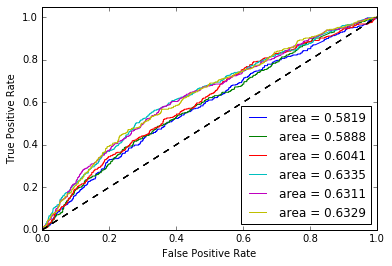

In [16]:
# compare 6 alternatives of text feature enginerin

vectorizer_process = CountVectorizer(preprocessor =empty_preprocessor,analyzer='char',stop_words='english')
train_matrix_process_text= vectorizer_process.fit_transform(train_text)
dev_matrix_process_text = vectorizer_process.transform(dev_text)
train_log(train_matrix_process_text,dev_matrix_process_text)

vectorizer_process = CountVectorizer(preprocessor =first_preprocessor,analyzer='char',stop_words='english')
train_matrix_process_text= vectorizer_process.fit_transform(train_text)
dev_matrix_process_text = vectorizer_process.transform(dev_text)
train_log(train_matrix_process_text,dev_matrix_process_text)

vectorizer_process = CountVectorizer(preprocessor =second_preprocessor,analyzer='char',stop_words='english')
train_matrix_process_text= vectorizer_process.fit_transform(train_text)
dev_matrix_process_text = vectorizer_process.transform(dev_text)
train_log(train_matrix_process_text,dev_matrix_process_text)

# 1.Convert Text to word features based on TF-IDF

vectorizer_process = TfidfVectorizer(preprocessor =empty_preprocessor,analyzer='word',stop_words='english',ngram_range=(1, 8) )
train_matrix_process_text= vectorizer_process.fit_transform(train_text)
dev_matrix_process_text = vectorizer_process.transform(dev_text)
train_log(train_matrix_process_text,dev_matrix_process_text)

vectorizer_process = TfidfVectorizer(preprocessor =first_preprocessor,analyzer='word',stop_words='english',ngram_range=(1, 8) )
train_matrix_process_text= vectorizer_process.fit_transform(train_text)
dev_matrix_process_text = vectorizer_process.transform(dev_text)
train_log(train_matrix_process_text,dev_matrix_process_text)

vectorizer_process = TfidfVectorizer(preprocessor =second_preprocessor,analyzer='word',stop_words='english',ngram_range=(1, 8) )
train_matrix_process_text= vectorizer_process.fit_transform(train_text)
dev_matrix_process_text = vectorizer_process.transform(dev_text)
train_log(train_matrix_process_text,dev_matrix_process_text)

Optimal number of features : 232625


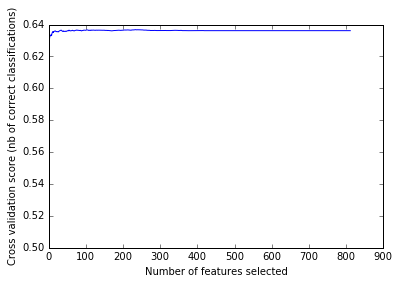

Number of positive prediction: 0
Model F-Score = 0.0000 
Accuracy = 0.7412
accuracy_score: 0.000000
recall_score: 0.0000
roc_auc_score: 0.5000


/Users/Maximus/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1075: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


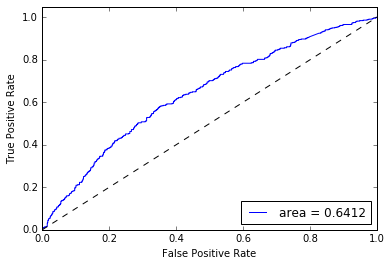

In [19]:
# 2.Feature ranking with recursive feature elimination & cross-validated selection of the best number of features.
from sklearn.svm import SVC
from sklearn.cross_validation import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn import cross_validation

# Build a LogisticRegression Classifier with L2 Regularization

logistic  = LogisticRegression(penalty ='l2',C=0.1)

rfecv = RFECV(estimator=logistic , step= 100, cv=4,scoring='roc_auc')
rfecv.fit(train_matrix_process_text, train_labels)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

cv_features=train_matrix_process_text[:,rfecv.support_]
cv_features_dev= dev_matrix_process_text[:,rfecv.support_]

logistic = LogisticRegression(penalty ='l2',C=0.1)#C from the above test
logistic.fit(cv_features, train_labels)


preds = logistic.predict(cv_features_dev)
pred_probas = logistic.predict_proba(cv_features_dev)
F_Score = metrics.f1_score(dev_labels, preds, average='binary')


# Call to display outputs
model_output(pred_probas, F_Score, preds)

In [51]:
cv_features=train_matrix_process_text[:,rfecv.support_]
cv_features_dev= dev_matrix_process_text[:,rfecv.support_]

logistic = LogisticRegression(penalty ='l2',C= 0.1)#C from the above test
logistic.fit(cv_features, train_labels)


preds = logistic.predict(cv_features_dev)
pred_probas = logistic.predict_proba(cv_features_dev)
F_Score = metrics.f1_score(dev_labels, preds, average='binary')


# Call to display outputs
model_output(pred_probas, F_Score, preds)
fpr,tpr,_ = roc_curve(dev_labels, pred_probas[:,1])
roc_auc = metrics.auc(fpr,tpr)
print(roc_auc)

AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [20]:
# Add Narratives

desire = re.compile(r'(friend|party|birthday|boyfriend|girlfriend|date|drinks|drunk|wasted|invite|invited|celebrate|celebrating|game|games|movie|beer|crave|craving|gf)', re.IGNORECASE)
family = re.compile(r'(husband|wife|family|parent|parents|mother|father|mom|mum|son|dad|daughter|firstborn|pregnancy )', re.IGNORECASE)
job = re.compile(r'(job|unemployment|employment|hire|hired|fired|interview|work)', re.IGNORECASE)
money = re.compile(r'(money|bill|bills|rent|bank|account|paycheck|due|broke|bills|deposit|cash|dollar|dollars|bucks|paid|payed|buy|check|spent|financial|poor|loan|\
credit|budget|day|now|time|week|until|last|month|tonight|today|next|night|when|tomorrow|first|after|while|before|long|hour|Friday|ago|still|due|past|soon|current|years|never|till|yesterday|morning|evening)', re.IGNORECASE)
student = re.compile(r'(college|student|university|finals|study|studying|class|semester|school|roommate|project|tuition|dorm)', re.IGNORECASE)
mood = re.compile(r'(thank|thanks|thankful|appreciate|grateful|gratitude|advance)', re.IGNORECASE) 
holiday = re.compile(r'(anniversary|chirstmas)', re.IGNORECASE)   

def myfunc(a,b):
    if len(a)==0:
        return 0 
    else:
        return len(b.findall(a))/float(len(a))

In [22]:
narrative_all=np.zeros(shape=(len(train_text),6),dtype=int)
narrative_all_dev=np.zeros(shape=(len(dev_text),6),dtype=int)

for index,i in enumerate([family,desire,holiday,mood,job,money]):
    
    vfunc = np.vectorize(myfunc)
    narrative=vfunc(train_title+train_text,i)
    med=np.median(narrative)
    narrative_all[:,index]=np.where(narrative>0,1,0)
    
    narrative_dev=vfunc(dev_title+dev_text,i)
    med=np.median(narrative_dev)
    narrative_all_dev[:,index]=np.where(narrative_dev>0,1,0)

Check results from

Number of positive prediction: 16
Model F-Score = 0.0264 
Accuracy = 0.7388
accuracy_score: 0.375000
recall_score: 0.0137
roc_auc_score: 0.5029
0.652601468224
cell ran


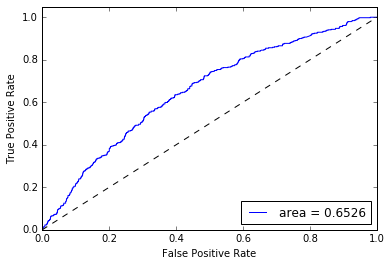

In [23]:
train_narrative=np.concatenate((cv_features.toarray(), narrative_all), axis=1)
dev_narrative=np.concatenate((cv_features_dev.toarray(), narrative_all_dev), axis=1)


logistic = LogisticRegression(penalty ='l2',C=1)#C from the above test
logistic.fit(train_narrative, train_labels.values.flatten())


preds = logistic.predict(dev_narrative)
pred_probas = logistic.predict_proba(dev_narrative)
F_Score = metrics.f1_score(dev_labels, preds, average='binary')


# Call to display outputs
model_output(pred_probas, F_Score, preds)
fpr,tpr,_ = roc_curve(dev_labels, pred_probas[:,1])
roc_auc = metrics.auc(fpr,tpr)
print(roc_auc)

(3975, 232632)
Number of positive prediction: 17
Model F-Score = 0.0307 
Accuracy = 0.7394
accuracy_score: 0.411765
recall_score: 0.0159
roc_auc_score: 0.5040
0.652676673499


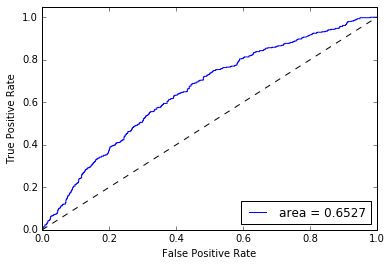

In [26]:
# Add capitalized word on Title

train_caps = train_data['request_title'].apply(lambda x: np.where(sum(1 for c in re.split('\W+',x) if c.isupper() and len(c) > 5) > 0, 1,0)).as_matrix()
dev_caps = dev_data['request_title'].apply(lambda x: np.where(sum(1 for c in re.split('\W+',x) if c.isupper() and len(c) > 5) > 0, 1,0)).as_matrix()
train_caps=train_caps.reshape(len(train_caps),1) 
dev_caps=dev_caps.reshape(len(dev_caps),1) 

train_narrative_excl_cap=np.concatenate((train_narrative, train_caps), axis=1)
dev_narrative_excl_cap=np.concatenate((dev_narrative, dev_caps), axis=1)
print(train_narrative_excl_cap.shape)


logistic = LogisticRegression(penalty ='l2',C=1)#C from the above test
logistic.fit(train_narrative_excl_cap, train_labels)


preds = logistic.predict(dev_narrative_excl_cap)
pred_probas = logistic.predict_proba(dev_narrative_excl_cap)
F_Score = metrics.f1_score(dev_labels, preds, average='binary')


# Call to display outputs
model_output(pred_probas, F_Score, preds)
fpr,tpr,_ = roc_curve(dev_labels, pred_probas[:,1])
roc_auc = metrics.auc(fpr,tpr)
print(roc_auc)


In [50]:
# L1 Regularization

for c in np.arange(0.1,20,0.5):
    
    Logistic_L1 = LogisticRegression(penalty ='l1',C=c)#C from the above test
    Logistic_L1.fit(train_narrative_excl_cap, np.ravel(train_labels))

    #Update the new index
    index=[]
    for i,z in enumerate(np.sum(np.abs(Logistic_L1.coef_),axis=0) ):
        if z!=0:
            index.append(i)

    train_features_final=train_narrative_excl_cap[:,index]
    dev_features_final=dev_narrative_excl_cap[:,index]

    Logistic_L2 = LogisticRegression(penalty ='l2',C=1)#C from the above test
    Logistic_L2.fit(train_features_final, np.ravel(train_labels))

    preds = Logistic_L2.predict(dev_features_final)
    pred_probas = Logistic_L2.predict_proba(dev_features_final)
    F_Score = metrics.f1_score(np.ravel(dev_labels), preds, average='binary')


    #Call to display outputs
#     model_output(pred_probas, F_Score, preds) #Please input pred_probas, F_Score, and prediction(preds)
    fpr,tpr,_ = roc_curve(dev_labels, pred_probas[:,1])
    roc_auc = metrics.auc(fpr,tpr)
    print ('C=%.2f, auc=%.5f, %i features selected. ' %(c,roc_auc,len(index)))


C=0.10, auc=0.59958, 4 features selected. 
C=0.60, auc=0.61129, 8 features selected. 
C=1.10, auc=0.62673, 12 features selected. 
C=1.60, auc=0.63779, 27 features selected. 
C=2.10, auc=0.64261, 47 features selected. 
C=2.60, auc=0.64567, 75 features selected. 
C=3.10, auc=0.64721, 120 features selected. 
C=3.60, auc=0.65011, 158 features selected. 
C=4.10, auc=0.64899, 217 features selected. 
C=4.60, auc=0.64746, 269 features selected. 
C=5.10, auc=0.64705, 322 features selected. 
C=5.60, auc=0.64745, 365 features selected. 
C=6.10, auc=0.64305, 401 features selected. 
C=6.60, auc=0.64318, 477 features selected. 
C=7.10, auc=0.64316, 651 features selected. 
C=7.60, auc=0.64397, 723 features selected. 
C=8.10, auc=0.64453, 779 features selected. 
C=8.60, auc=0.64358, 982 features selected. 
C=9.10, auc=0.64394, 1060 features selected. 
C=9.60, auc=0.64316, 1446 features selected. 
C=10.10, auc=0.64311, 1561 features selected. 
C=10.60, auc=0.64403, 1650 features selected. 
C=11.10, auc

Number of positive prediction: 0
Model F-Score = 0.0000 
Accuracy = 0.7412
accuracy_score: 0.000000
recall_score: 0.0000
roc_auc_score: 0.5000
C=8, auc=0.59958, 4 features selected. 


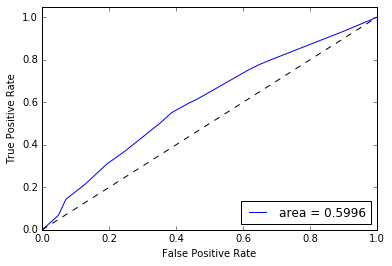

In [39]:
Logistic_L1 = LogisticRegression(penalty ='l1',C=0.1)#C from the above test
Logistic_L1.fit(train_narrative_excl_cap, np.ravel(train_labels))

#Update the new index
index=[]
for i,z in enumerate(np.sum(np.abs(Logistic_L1.coef_),axis=0) ):
    if z!=0:
        index.append(i)

train_features_final=train_narrative_excl_cap[:,index]
dev_features_final=dev_narrative_excl_cap[:,index]

Logistic_L2 = LogisticRegression(penalty ='l2',C=1)#C from the above test
Logistic_L2.fit(train_features_final, np.ravel(train_labels))

preds = Logistic_L2.predict(dev_features_final)
pred_probas = Logistic_L2.predict_proba(dev_features_final)
F_Score = metrics.f1_score(np.ravel(dev_labels), preds, average='binary')


#Call to display outputs
model_output(pred_probas, F_Score, preds) #Please input pred_probas, F_Score, and prediction(preds)
fpr,tpr,_ = roc_curve(dev_labels, pred_probas[:,1])
roc_auc = metrics.auc(fpr,tpr)
print ('C=%i, auc=%.5f, %i features selected. ' %(8,roc_auc,len(index)))

{'C': 0.5}
0.582741350456


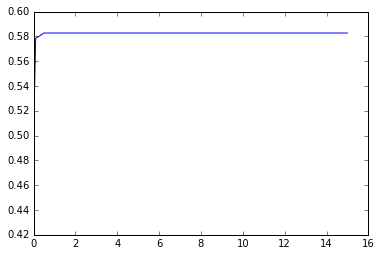

In [49]:
# Hyper-Parameter Tuning and compare models

from sklearn.grid_search import GridSearchCV
classifier = LogisticRegression(penalty ='l2')
Cs = {'C': [ 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0, 13.0, 15.0, 17.0, 20.0, 23.0, 27, 30, 33, 37]}

clf = GridSearchCV(classifier, Cs,scoring ='roc_auc',cv=2)
clf.fit(train_features_final, np.ravel(train_labels))
print(clf.best_params_)
print(clf.best_score_)

score=[]
para=[]
for i in range(10):
    score.append(clf.grid_scores_[i][1])
    para.append(clf.grid_scores_[i][0]['C'])

plt.plot(para,score)
# plt.plot(para,score)

In [ ]:
C_best=clf.best_params_['C']


Logistic_L2 = LogisticRegression(penalty ='l2',C=C_best)#C from the above test
Logistic_L2.fit(train_features_final, np.ravel(train_labels))

preds = Logistic_L2.predict(dev_features_final)
pred_probas = Logistic_L2.predict_proba(dev_features_final)
F_Score = metrics.f1_score(np.ravel(dev_labels), preds, average='binary')


#Call to display outputs
model_output(pred_probas, F_Score, preds) #Please input pred_probas, F_Score, and prediction(preds)
fpr,tpr,_ = roc_curve(dev_labels, pred_probas[:,1])
roc_auc = metrics.auc(fpr,tpr)
print (roc_auc)

{'kernel': 'linear', 'C': 1000}
0.747505690232
Number of positive prediction: 0
Model F-Score = 0.0000 
Accuracy = 0.7412
accuracy_score: 0.000000
recall_score: 0.0000
roc_auc_score: 0.5000
0.606725344902


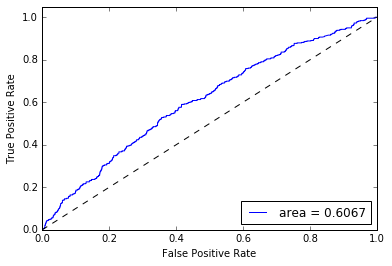

In [29]:
from sklearn.svm import SVC

tuned_parameters = [
                    {'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]


# Build a SVM Classifier with linear kernel
classifier = SVC()

clf = GridSearchCV(classifier,tuned_parameters,scoring ='roc_auc', cv=5)
clf.fit(train_features_final, train_labels)
print(clf.best_params_)
print(clf.best_score_)

svc= SVC(C=1000 , kernel='rbf',gamma= 0.0001,probability=True)#C from the above test
# svc= SVC(C=1000 , kernel='linear',probability=True) ##this is too bad

svc.fit(train_features_final, np.ravel(train_labels))

preds = svc.predict(dev_features_final)
pred_probas = svc.predict_proba(dev_features_final)
F_Score = metrics.f1_score(np.ravel(dev_labels), preds, average='binary')


#Call to display outputs
model_output(pred_probas, F_Score, preds) #Please input pred_probas, F_Score, and prediction(preds)
fpr,tpr,_ = roc_curve(dev_labels, pred_probas[:,1])
roc_auc = metrics.auc(fpr,tpr)
print (roc_auc)

In [31]:
print train_features_final.shape
print dev_features_final.shape

(3975, 322)
(1696, 322)


# Model Optimization

Test the result with a basic logistic regression with previously determine hyperparameters c = 0.1 for both L1 and L2

Number of positive prediction: 225
Model F-Score = 0.5783 
Accuracy = 0.8349
precision_score: 0.853333
recall_score: 0.4374
roc_auc_score: 0.8658


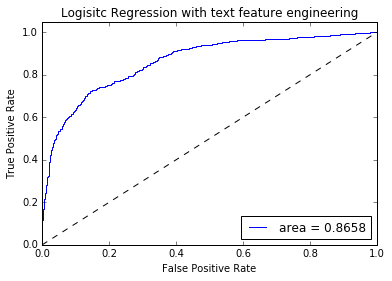

In [130]:
#Combine text features with numerical features; text features engineering from above
np.random.seed(0)
#######################Transformed Text features to sparse matrix

index = L1_regulation(0.1, train_features_final, train_labels)

# Append along columns with axis=1. that is, append along x axis
# Combine numerical features with text features
all_data_train = 0
all_data_train = np.append(word_matrix_process[:,index].toarray(), train_data_numeric, 1)

model_LG = LogisticRegression(penalty ='l2', C = 0.1)#C from the above test
model_LG.fit(all_data_train, train_labels)

all_data_dev = 0
all_data_dev = np.append(dev_matrix_process[:,index].toarray(), dev_data_numeric, 1)

preds = model_LG.predict(all_data_dev)
F_Score = metrics.f1_score(dev_labels, preds, average='binary')
pred_probas = model_LG.predict_proba(all_data_dev)

model_output(pred_probas, F_Score, preds, 'Logisitc Regression with text feature engineering')


Number of positive prediction: 285
Model F-Score = 0.6105 
Accuracy = 0.8337
precision_score: 0.775439
recall_score: 0.5034
roc_auc_score: 0.8667


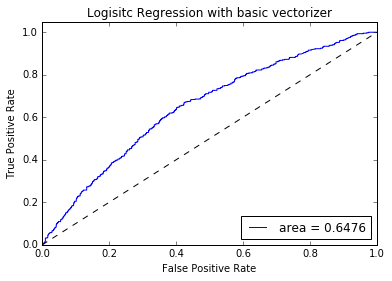

In [125]:
#Logisitc Regression Model with basic 
np.random.seed(0)
#######################Transformed Text features to sparse matrix
vectorizer_process = CountVectorizer(preprocessor =first_preprocessor,analyzer='word',stop_words='english',ngram_range=(1, 8))
word_matrix_process= vectorizer_process.fit_transform(train_all)
dev_matrix_process = vectorizer_process.transform(dev_all)

index = L1_regulation(0.1, word_matrix_process, train_labels)

# Append along columns with axis=1. that is, append along x axis
# Combine numerical features with text features
all_data_train = 0
all_data_train = np.append(word_matrix_process[:,index].toarray(), train_data_numeric, 1)

model_LG = LogisticRegression(penalty ='l2', C = 0.1)#C from the above test
model_LG.fit(all_data_train, train_labels)

all_data_dev = 0
all_data_dev = np.append(dev_matrix_process[:,index].toarray(), dev_data_numeric, 1)

preds = model_LG.predict(all_data_dev)
F_Score = metrics.f1_score(dev_labels, preds, average='binary')
pred_probas = model_LG.predict_proba(all_data_dev)

model_output(pred_probas, F_Score, preds, 'Logisitc Regression with basic vectorizer')


Due to the restrictions of linearity of logistic regression; we want to try using RandomForest to see if it yield beeter result:


Number of trees in forest: 300
Number of positive prediction: 215
Model F-Score = 0.5688 
Accuracy = 0.8337
precision_score: 0.865116
recall_score: 0.4237
roc_auc_score: 0.8692


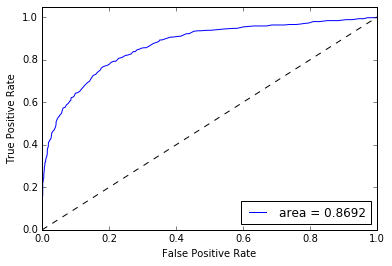

In [115]:
# Import the random forest package
from sklearn.ensemble import RandomForestClassifier 

#Best non-ensemble method so far
np.random.seed(0)

vectorizer_process = CountVectorizer(preprocessor =first_preprocessor,analyzer='word',stop_words='english',ngram_range=(1, 8))
word_matrix_process= vectorizer_process.fit_transform(train_all)
dev_matrix_process = vectorizer_process.transform(dev_all)

index = L1_regulation(0.1, word_matrix_process, train_labels)

# Append along columns with axis=1. that is, append along x axis
# Combine numerical features with text features
all_data_train = 0
all_data_dev = 0
all_data_train = np.append(word_matrix_process[:,index].toarray(), train_data_numeric, 1)
all_data_dev = np.append(dev_matrix_process[:,index].toarray(), dev_data_numeric, 1)

for i in [300]:

    # Create the random forest object which will include all the parameters
    forest = RandomForestClassifier(n_estimators = i)

    # Fit RandomForest
    # don't use transform method (at least not yet) -- which would reduce to best features -- 
    # as we want to keep and try these
    forest = forest.fit(all_data_train, train_labels)


    # Take the same decision trees and run it on the test data
    preds = forest.predict(all_data_dev)

    #preds = model_LG.predict(all_data_dev)
    F_Score = metrics.f1_score(dev_labels, preds, average='binary')
    pred_probas = forest.predict_proba(all_data_dev)

    print "\n", "Number of trees in forest: %s" % (i)
    #Call to display outputs
    model_output(pred_probas, F_Score, preds) #Please input pred_probas, F_Score, and prediction(preds)

Improve AUC with Ensemble Method 

In [116]:
#Create inputs for Ensemble Method
#Ensemble Model = RF + NB + LG
#vectorizer_process = CountVectorizer(analyzer='word',stop_words='english',preprocessor = first_preprocessor)
#word_matrix_process= vectorizer_process.fit_transform(train_all)
#dev_matrix_process = vectorizer_process.transform(dev_all)

#Update the new index
#index = L1_regulation(0.1, word_matrix_process, train_labels)

#all_data_train = 0
#all_data_train = np.append(train_features_final, train_data_numeric, 1)
#all_data_dev = 0
#all_data_dev = np.append(dev_features_final, dev_data_numeric, 1)

#Naive Bayes        
bnb = BernoulliNB(alpha=0.001, binarize=0.5)
bnb.fit(all_data_train, train_labels)
NB_t = bnb.predict_proba(all_data_train)
NB_d = bnb.predict_proba(all_data_dev)

#L2 Regression
model_LG = LogisticRegression(penalty ='l2', C=0.1)#C from the above test
model_LG.fit(all_data_train, train_labels)
LG_t = model_LG.predict_proba(all_data_train)
LG_d = model_LG.predict_proba(all_data_dev)

print "Done"

Done


Number of positive prediction: 274
Model F-Score = 0.6031 
Accuracy = 0.8331
precision_score: 0.784672
recall_score: 0.4897
roc_auc_score: 0.8672


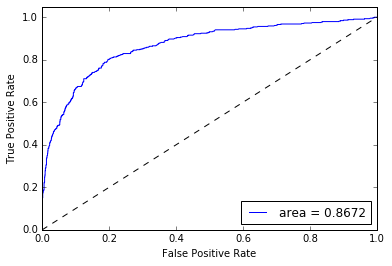

In [118]:
#Putting the pieces together - final Ensemble Model
#Update the new index
all_data_train = 0
all_data_train = np.append(word_matrix_process[:,index].toarray(), train_data_numeric, 1)
all_data_train = np.insert(all_data_train, all_data_train.shape[1], LG_t[:,1], axis=1)  #LG output
#all_data_train = np.insert(all_data_train, all_data_train.shape[1], NB_t[:,1], axis=1)

all_data_dev = 0
all_data_dev = np.append(dev_matrix_process[:,index].toarray(), dev_data_numeric, 1)
all_data_dev = np.insert(all_data_dev, all_data_dev.shape[1], LG_d[:,1], axis=1)
#all_data_dev = np.insert(all_data_dev, all_data_dev.shape[1], NB_d[:,1], axis=1)


for i in [7000]:
# Create the random forest object which will include all the parameters
    forest = RandomForestClassifier(n_estimators = i)

# Fit the training data to the Survived labels and create the decision trees
    forest = forest.fit(all_data_train, train_labels)

# Take the same decision trees and run it on the test data
    preds = forest.predict(all_data_dev)

    F_Score = metrics.f1_score(dev_labels, preds, average='binary')
    pred_probas = forest.predict_proba(all_data_dev)
#Call to display outputs
    model_output(pred_probas, F_Score, preds) #Please input pred_probas, F_Score, and prediction(preds)

# Appendix

# Random Acts of Pizza (RAOP) Notes

**Source**: Althoff, T., Danescu-Niculescu-Mizil, C., & Jurafsky, D. (2014). *How to Ask for a Favor: A Case Study on the Success of Altruistic Requests*. Association for the Advancement of Artificial
Intelligence (www.aaai.org).

- "The community only publishes which users have given or received pizzas but not which requests were successful. 
In the case of successful users posting multiple times it is unclear which of the requests was actually successful. 
Therefore, we restrict our analysis to users with a single request for which we can be certain whether or not 
it was successful, leaving us with 5728 pizza requests. We split this dataset into development (70%) and test set (30%) such that both sets mirror the average success rate in our dataset of 24.6%. All features are developed on the 
development test only while the test set is used only once to evaluate the prediction accuracy of our proposed model on held-out data. For a small number of requests (379) we further observe the identity of the benefactor through a 
'thank you' post by the beneficiary after the successful request. This enables us to reason about the impact of 
user similarity on giving."


- "It is extremely difficult to disentangle the effects of all these factors in determining what makes people satisfy requests, and what makes them select some requests over others. . . In this paper, we develop a framework for controlling for each of these potential confounds while studying the role of two aspects that characterize compelling requests: **social factors** (who is asking and how the recipient is related to the donor and community) and **linguistic factors** (how they are asking and what linguistic devices accompany successful requests). With the notable exception of Mitra and Gilbert (2014), the effect of language on the success of requests has largely been ignored thus far."


- "[Their] goal is to understand what motivates people to give when they do not receive anything tangible in return. That is, [they] focus on the important special case of altruistic requests in which the giver receives no rewards." **DSC**: But how do you know people don't want something in return, especially if they are more likely to help requesters who have high status or are more similar to them?

-----

Temporal Factors
- Specific months
- Weekdays
- **Days of the month (first half of the month)**
- Hour of the day
- **Community age of the request (earlier the better)**

Textual Factors
- Politeness (e.g., **gratitude**)
- **Evidentiality** (2nd largest parameter estimate)
- Reciprocity (respond to a positive action with another positive action, **pay it forward**)
- Sentiment (e.g., **urgency**)
- **Length**

Social Factors
- **Status**
    - karma points (up-votes minus down-votes) that Reddit counts on link submissions and comments,
    - user has posted on RAOP before and thus could be considered a member of the sub-community. 
    - **user account age based on the hypothesis that “younger” accounts might be less trusted**


- Similarity: intersection size between the set of the giver and receiver, and the Jaccard similarity (intersection
over union) of the two. NOT included in logistic regression model.

Narratives (identified through topic modeling)
- **Desire**
- **Family**
- **Job**
- **Money**
- Student

-----

Conclusion
- Drawing from social psychology literature [they] extract high-level social features from text that operationalize the relation between recipient and donor and demonstrate that these extracted relations are predictive of success. 
- [They] show that [they] can detect key narratives automatically that have significant impact on the success of the request. 
- [They] further demonstrate that linguistic indications of gratitude, evidentiality, and reciprocity, as well as the high status of the asker, all increase the likelihood of success, while neither politeness nor positive sentiment seem to be associated with success in [the] setting.

Limitations
- A shortcoming of any case study is that findings might be specific to the scenario at hand. While [they] have shown that particular linguistic and social factors differentiate between successful and unsuccessful requests [they] cannot claim a causal relationship between the proposed factors and success that would guarantee success. 
- Furthermore, the set of success factors studied in this work is likely to be incomplete as well and excludes,
for instance, group behavior dynamics. 
- Despite these limitations, [they] hope that this work and the data [they] make available will provide a basis for further research on success factors and helping behavior in other online communities.

-----

In [ ]:
'''Feature Selection
http://scikit-learn.org/stable/modules/feature_selection.html

These objects take as input a scoring function that returns univariate p-values:
-For regression: f_regression
-For classification: chi2 or f_classif

Feature selection with sparse data:
-If you use sparse data (i.e. data represented as sparse matrices), 
only chi2 will deal with the data without making it dense.
-Warning: Beware not to use a regression scoring function with a classification problem, 
you will get useless results.

With SVMs and logistic-regression, the parameter C controls the sparsity: 
the smaller C the less features selected. 

In [18]:
#Create ROC Curve (to visualize and evaluate classifer output quality)
    # http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
    # Decreasing thresholds on decision function used to compute fpr and tpr. 
    # thresholds[0] represents no instances being predicted and is arbitrarily 
    # set to max(y_score) + 1.
    
# http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score
    
# 'macro':
# Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.
# 'weighted':
# Calculate metrics for each label, and find their average, weighted by support (the number of true instances for each label).
      
    
    # “A receiver operating characteristic (ROC), or simply ROC curve, is a 
    # graphical plot which illustrates the performance of a binary classifier 
    # system as its discrimination threshold is varied. It is created by plotting 
    # the fraction of true positives out of the positives (TPR = true positive rate) 
    # vs. the fraction of false positives out of the negatives 
    # (FPR = false positive rate), at various threshold settings. 
    # TPR is also known as sensitivity, and FPR is one minus the specificity 
    # or true negative rate.”

# Feature Selection Notes:

    #http://scikit-learn.org/stable/datasets/twenty_newsgroups.html
    #http://scikit-learn.org/stable/modules/feature_selection.html
    #http://scikit-learn.org/stable/auto_examples/text/document_classification_20newsgroups.html#example-text-document-classification-20newsgroups-py

    #These objects take as input a scoring function that returns univariate p-values:
    #-For regression: f_regression
    #-For classification: chi2 or f_classif

    #Feature selection with sparse data:
    #-If you use sparse data (i.e. data represented as sparse matrices), 
    #only chi2 will deal with the data without making it dense.
    #-Warning: Beware not to use a regression scoring function with a classification problem, 
    #you will get useless results.

    #With SVMs and logistic-regression, the parameter C controls the sparsity: 
    #the smaller C the less features selected.   

# Preprocessor:
   #-----
   # write variation of code, but remove ending s (make plural words singular)
   # http://stackoverflow.com/questions/3675318/how-to-replace-the-some-characters-from-the-end-of-a-string